In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #makes the display bars longer and spread out 100% across the screen width


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

!pwd
!whoami
!date

/ihme/homes/nicoly/vivarium_research_ciff_sam/model_validation/model2
nicoly
Tue Aug 10 01:39:46 PDT 2021


# 2.4: WASTING (RISK validation)

## wasting risk vv

In [3]:
%cd /ihme/costeffectiveness/results/vivarium_ciff_sam/v2.4_corrected_fertility/ciff_sam/2021_08_03_15_08_32/count_data
%ls

/ihme/costeffectiveness/results/vivarium_ciff_sam/v2.4_corrected_fertility/ciff_sam/2021_08_03_15_08_32/count_data
deaths.csv                     population.csv                 ylds.csv
deaths.hdf                     population.hdf                 ylds.hdf
disease_state_person_time.csv  wasting_state_person_time.csv  ylls.csv
disease_state_person_time.hdf  wasting_state_person_time.hdf  ylls.hdf
disease_transition_count.csv   wasting_transition_count.csv
disease_transition_count.hdf   wasting_transition_count.hdf


In [4]:
master_dir = '/home/j/Project/simulation_science/ciff_malnutrition/'
sim_result_dir = '/ihme/costeffectiveness/results/vivarium_ciff_sam/v2.4_corrected_fertility/ciff_sam/2021_08_03_15_08_32/count_data/' 
output_dir = master_dir + f'verification_and_validation/v2.4_corrected_fertility/'

## LOAD SIM DATA

In [5]:
def load_sim_count_data(sim_result_dir: str):
    columns = ['age', 'sex', 'year', 'input_draw', 'scenario', 'measure']
    df = {}
    fnames = ['deaths', 'disease_transition_count', 'wasting_transition_count',
              'disease_state_person_time', 'wasting_state_person_time']
    for fname in fnames:
        df[fname] = pd.read_csv(sim_result_dir + fname + '.csv', index_col=0)
        # get aggregated results if stratifications exist
        if 'cause' in df[fname].columns:
            df[fname] = df[fname].groupby(columns + ['cause']).value.sum().reset_index()
        else:
            df[fname] = df[fname].groupby(columns).value.sum().reset_index()
    return df

df = load_sim_count_data(sim_result_dir)

In [6]:
pd.read_csv(sim_result_dir + 'wasting_transition_count.csv', index_col=0).query('measure == "susceptible_to_child_wasting_to_mild_child_wasting_event_count"')

,sex,year,measure,input_draw,scenario,value,age
432,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,116.0,early_neonatal
433,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,372.0,late_neonatal
434,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,3182.0,1-5_months
435,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,3770.0,6-11_months
...,...,...,...,...,...,...,...
5036,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,baseline,3305.0,1-5_months
5037,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,baseline,4342.0,6-11_months
5038,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,baseline,8595.0,12_to_23_months
5039,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,baseline,22867.0,2_to_4


In [7]:
results = pd.read_csv(sim_result_dir + 'wasting_transition_count.csv', index_col=0)
incidence_mild_count = results.query('measure == "susceptible_to_child_wasting_to_mild_child_wasting_event_count"')
incidence_mild_count.head()

,sex,year,measure,input_draw,scenario,value,age
432,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,116.0,early_neonatal
433,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,372.0,late_neonatal
434,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,3182.0,1-5_months
435,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,3770.0,6-11_months
436,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,7270.0,12_to_23_months


In [8]:
incidence_mild_count \
.groupby(['year','age']) \
.sum().drop(columns='input_draw').reset_index().set_index(['age']) \
.pivot(columns = 'year')

value                                        
year                 2022      2023      2024      2025      2026
age                                                              
1-5_months        80972.0   80970.0   81605.0   81001.0   80794.0
12_to_23_months  191293.0  195462.0  197132.0  196755.0  197390.0
2_to_4           515358.0  518669.0  524946.0  527456.0  532509.0
6-11_months       97600.0   98507.0   99254.0   98604.0   98781.0
early_neonatal     3317.0    3220.0    3264.0    3279.0    3239.0
late_neonatal      9626.0    9440.0    9430.0    9629.0    9464.0

### WASTING STATE TRANSITION COUNTS

In [9]:
incidence_mild_count = (df['wasting_transition_count'].query('measure == "susceptible_to_child_wasting_to_mild_child_wasting_event_count"'))
incidence_mild_count['risk'] = 'mild_wasting'
incidence_mild_count['measure'] = 'incidence'

incidence_mam_count = (df['wasting_transition_count'].query('measure == "mild_child_wasting_to_moderate_acute_malnutrition_event_count"'))
incidence_mam_count['risk'] = 'mam'
incidence_mam_count['measure'] = 'incidence'

incidence_sam_count = (df['wasting_transition_count'].query('measure == "moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count"'))
incidence_sam_count['risk'] = 'sam'
incidence_sam_count['measure'] = 'incidence'

remission_sam_count = (df['wasting_transition_count'].query('measure == "severe_acute_malnutrition_to_moderate_acute_malnutrition_event_count"'))
remission_sam_count['risk'] = 'sam'
remission_sam_count['measure'] = 'remission'

remission_mam_count = (df['wasting_transition_count'].query('measure == "moderate_acute_malnutrition_to_mild_child_wasting_event_count"'))
remission_mam_count['risk'] = 'mam'
remission_mam_count['measure'] = 'remission'

remission_mild_count = (df['wasting_transition_count'].query('measure == "mild_child_wasting_to_susceptible_to_child_wasting_event_count"'))
remission_mild_count['risk'] = 'mild_wasting'
remission_mild_count['measure'] = 'remission'

### WASTING STATE PERSON TIME

In [10]:
person_time_sus_wasting = df['wasting_state_person_time'].query('cause == "susceptible_to_child_wasting"')
person_time_mild_wasting = df['wasting_state_person_time'].query('cause == "mild_child_wasting"')
person_time_mam = df['wasting_state_person_time'].query('cause == "moderate_acute_malnutrition"')
person_time_sam = df['wasting_state_person_time'].query('cause == "severe_acute_malnutrition"')

#### TOTAL PERSON TIME

In [11]:
df['disease_person_time'] = df['disease_state_person_time'].loc[
    df['disease_state_person_time'].cause.isin(['diarrheal_diseases','susceptible_to_diarrheal_diseases'])
].groupby(['age','sex','year','input_draw','scenario','measure']).sum().reset_index()

df['disease_person_time']['cause'] = 'all_causes'

In [12]:
df['disease_person_time']

,age,sex,year,input_draw,scenario,measure,value,cause
0,1-5_months,female,2022,29,baseline,state_person_time,43265.013005,all_causes
1,1-5_months,female,2022,223,baseline,state_person_time,42902.629706,all_causes
2,1-5_months,female,2022,232,baseline,state_person_time,43689.839836,all_causes
3,1-5_months,female,2022,357,baseline,state_person_time,42806.331280,all_causes
...,...,...,...,...,...,...,...,...
716,late_neonatal,male,2026,650,baseline,state_person_time,6258.131417,all_causes
717,late_neonatal,male,2026,680,baseline,state_person_time,6279.897331,all_causes
718,late_neonatal,male,2026,829,baseline,state_person_time,6308.962355,all_causes
719,late_neonatal,male,2026,946,baseline,state_person_time,6180.350445,all_causes


In [13]:
df['disease_state_person_time'].loc[
    df['disease_state_person_time'].cause.isin(['diarrheal_diseases','susceptible_to_diarrheal_diseases'])].value.sum()

61136436.77481176

In [14]:
df['risk_person_time'] = df['wasting_state_person_time'].groupby(['age','sex','year','input_draw','scenario','measure']).sum().reset_index()
df['risk_person_time']['cause'] = 'all_causes'

In [15]:
# i think the disease person time v risk person time should be equal
df['disease_person_time'].value.sum()

61136436.77481177

In [16]:
df['risk_person_time'].value.sum()

61136436.77481177

In [17]:
pd.read_csv(sim_result_dir + 'population.csv', index_col=0)

,measure,input_draw,scenario,value
0,total_population,29,baseline,2047692.0
1,total_population,223,baseline,2048680.0
2,total_population,232,baseline,2090287.0
3,total_population,357,baseline,2046728.0
...,...,...,...,...
56,total_population_untracked,650,baseline,988248.0
57,total_population_untracked,680,baseline,990893.0
58,total_population_untracked,829,baseline,991879.0
59,total_population_untracked,946,baseline,978987.0


## CALCULATE SIM MEASURES

In [18]:
def get_measure(data: pd.DataFrame, denom: pd.DataFrame, entity: str):
    """
    rate per PY among source population
    note the numerator is 'data' and denominator is df['person_time']
    """
    
    result = ((data
               .set_index(['age', 'sex', 'year', 'input_draw', 'scenario', 'measure', entity])
               .div(denom.drop(columns=['measure', 'cause'])
                    .set_index(['age', 'sex', 'year', 'input_draw', 'scenario'])))
              .reset_index())
    
    result['age_group'] = np.where(result['age'] == 'early_neonatal', 1,
                              np.where(result['age'] == 'late_neonatal', 2,
                                       np.where(result['age'] == '1-5_months',3,
                                                np.where(result['age'] == '6-11_months',4,
                                                         np.where(result['age'] == '12_to_23_months',5,
                                                         6)))))
    
    result_summary = (result
                      .groupby(['age_group', 'sex', 'year', 'scenario', 'measure', entity])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
    
    return result_summary

In [19]:
df.keys()

dict_keys(['deaths', 'disease_transition_count', 'wasting_transition_count', 'disease_state_person_time', 'wasting_state_person_time', 'disease_person_time', 'risk_person_time'])

### PREVALENCE

In [20]:
# risk prevalence
prevalence_wasting_tmrel = get_measure(person_time_sus_wasting, df['risk_person_time'], 'cause')
prevalence_mild = get_measure(person_time_mild_wasting, df['risk_person_time'], 'cause')
prevalence_mam = get_measure(person_time_mam, df['risk_person_time'], 'cause')
prevalence_sam = get_measure(person_time_sam, df['risk_person_time'], 'cause')

In [21]:
prevalence_wasting_tmrel

,age_group,sex,year,scenario,measure,cause,mean,2.5%,97.5%
0,1,female,2022,baseline,state_person_time,susceptible_to_child_wasting,0.696872,0.690491,0.702761
1,1,female,2023,baseline,state_person_time,susceptible_to_child_wasting,0.696825,0.692393,0.702292
2,1,female,2024,baseline,state_person_time,susceptible_to_child_wasting,0.697012,0.693413,0.702473
3,1,female,2025,baseline,state_person_time,susceptible_to_child_wasting,0.697340,0.693114,0.703270
...,...,...,...,...,...,...,...,...,...
56,6,male,2023,baseline,state_person_time,susceptible_to_child_wasting,0.687339,0.681888,0.691037
57,6,male,2024,baseline,state_person_time,susceptible_to_child_wasting,0.680104,0.676265,0.683438
58,6,male,2025,baseline,state_person_time,susceptible_to_child_wasting,0.678510,0.675418,0.681167
59,6,male,2026,baseline,state_person_time,susceptible_to_child_wasting,0.679635,0.676681,0.682546


### INCIDENCE

In [22]:
incidence_mild = get_measure(incidence_mild_count, denom = person_time_sus_wasting, entity = 'risk')
incidence_mam = get_measure(incidence_mam_count, denom = person_time_mild_wasting, entity = 'risk')
incidence_sam = get_measure(incidence_sam_count, denom = person_time_mam, entity = 'risk')

### REMISSION

In [23]:
remission_mild = get_measure(remission_mild_count, denom = person_time_mild_wasting, entity = 'risk')
remission_mam = get_measure(remission_mam_count, denom = person_time_mam, entity = 'risk')
remission_sam = get_measure(remission_sam_count, denom = person_time_sam, entity = 'risk')

# ARTIFACT

In [24]:
#filepath

%cd /ihme/costeffectiveness/artifacts/vivarium_ciff_sam/
%ls

/ihme/costeffectiveness/artifacts/vivarium_ciff_sam
backup-2.hdf  backup.hdf  ethiopia.hdf


In [25]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf', filter_terms=['year_start == 2020', f'age_end <= 5'])

In [26]:
#load population structure

art_pop = art.load('population.structure').reset_index()

In [27]:
art_pop

,location,sex,age_start,age_end,year_start,year_end,value


In [28]:
def load_wasting_prev(cat):
    data = art.load('risk_factor.child_wasting.exposure')
    
    data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()

    data['age'] = 0
    
    data['age'] = np.where(data['age_start'] == 0, 'early_neonatal', #1
                                            np.where(data['age_end'] == 0.5, '1-5_months', #3
                                                     np.where(data['age_start'] == 0.5, '6-11_months', #4
                                                              np.where(data['age_start'] == 1, '12_to_23_months',  #5
                                                                       np.where(data['age_start'] == 2, '2_to_4',       #6
                                                                       'late_neonatal'))))) #2
        
    data['age_group'] = np.where(data['age'] == 'early_neonatal', 1,
                                   np.where(data['age'] == 'late_neonatal', 2,
                                            np.where(data['age'] == '1-5_months', 3, 
                                                     np.where(data['age'] == '6-11_months', 4, 
                                                              np.where(data['age'] == '12_to_23_months', 5,
                                    6)))))


    data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
    #subset to cat
    risk_dict = {
        'cat1':'sam',
        'cat2':'mam',
        'cat3':'mild_wasting',
        'cat4':'tmrel_wasting'
    }
    data['risk'] = data.parameter.map(risk_dict)
    data = data.loc[data.parameter==cat].drop(columns=['parameter'])
    data['measure'] = 'prevalence'
    
    return data

In [29]:
sam_prev = load_wasting_prev('cat1')
mam_prev = load_wasting_prev('cat2')
mild_prev = load_wasting_prev('cat3')
sus_wasting_prev = load_wasting_prev('cat4')

In [30]:
sam_prev

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age,age_group,risk,measure
0,female,0.000000,0.019178,2020,2021,0.023100,0.019989,0.026792,early_neonatal,1,sam,prevalence
4,female,0.019178,0.076712,2020,2021,0.023190,0.019931,0.027105,late_neonatal,2,sam,prevalence
8,female,0.076712,0.500000,2020,2021,0.023488,0.019865,0.027258,1-5_months,3,sam,prevalence
12,female,0.500000,1.000000,2020,2021,0.024330,0.020975,0.028153,6-11_months,4,sam,prevalence
...,...,...,...,...,...,...,...,...,...,...,...,...
32,male,0.076712,0.500000,2020,2021,0.038924,0.033626,0.044606,1-5_months,3,sam,prevalence
36,male,0.500000,1.000000,2020,2021,0.036829,0.031725,0.042338,6-11_months,4,sam,prevalence
40,male,1.000000,2.000000,2020,2021,0.027107,0.023106,0.031317,12_to_23_months,5,sam,prevalence
44,male,2.000000,5.000000,2020,2021,0.015216,0.012704,0.017818,2_to_4,6,sam,prevalence


In [31]:
sam_prev.year_start.unique()

array([2020])

In [32]:
data = art.load('risk_factor.child_wasting.exposure')
data

draw_0    draw_1  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.023691  0.020229   
                                              cat2       0.081477  0.077593   
                                              cat3       0.201531  0.202116   
                                              cat4       0.693301  0.700062   
...                                                           ...       ...   
Male   2.0       5.000000 2020       2021     cat1       0.017051  0.016065   
                                              cat2       0.076602  0.074009   
                                              cat3       0.212440  0.209770   
                                              cat4       0.693907  0.700157   

                                                           draw_2    draw_3  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.024571  0.023875   
                                              cat2       0.082827  0.080739   
                                              cat3       0.200484  0.198969   
                                              cat4       0.692118  0.696416   
...                                                           ...       ...   
Male   2.0       5.000000 2020       2021     cat1       0.014870  0.015129   
                                              cat2       0.072192  0.071776   
                                              cat3       0.208359  0.205463   
                                              cat4       0.704579  0.707632   

                                                           draw_4    draw_5  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.021238  0.026264   
                                              cat2       0.078294  0.083628   
                                              cat3       0.199892  0.197072   
                                              cat4       0.700577  0.693037   
...                                                           ...       ...   
Male   2.0       5.000000 2020       2021     cat1       0.012592  0.016254   
                                              cat2       0.068591  0.073189   
                                              cat3       0.210795  0.206674   
                                              cat4       0.708022  0.703884   

                                                           draw_6    draw_7  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.026441  0.020032   
                                              cat2       0.083192  0.075529   
                                              cat3       0.199198  0.196449   
                                              cat4       0.691168  0.707991   
...                                                           ...       ...   
Male   2.0       5.000000 2020       2021     cat1       0.014299  0.012835   
                                              cat2       0.072681  0.070231   
                                              cat3       0.212409  0.213074   
                                              cat4       0.700611  0.703861   

                                                           draw_8    draw_9  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.020898  0.024393   
                                              cat2       0.077394  0.081932   
                                              cat3       0.200314  0.201837   
                                              cat4       0.701394  0.691838   
...                                                           ...       ...   
Male   2.0       5.000000 

In [33]:
df['deaths'].input_draw.unique()

array([ 29, 223, 232, 357, 394, 524, 602, 629, 650, 680, 829, 946])

In [34]:
draws = [f'draw_{i}' for i in df['deaths'].input_draw.unique()]
data[draws]

draw_29  draw_223  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.023281  0.024511   
                                              cat2       0.081848  0.081265   
                                              cat3       0.204284  0.198210   
                                              cat4       0.690588  0.696013   
...                                                           ...       ...   
Male   2.0       5.000000 2020       2021     cat1       0.015465  0.015713   
                                              cat2       0.072813  0.072120   
                                              cat3       0.210358  0.208431   
                                              cat4       0.701364  0.703736   

                                                         draw_232  draw_357  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.022513  0.020079   
                                              cat2       0.079587  0.078504   
                                              cat3       0.200825  0.203961   
                                              cat4       0.697075  0.697456   
...                                                           ...       ...   
Male   2.0       5.000000 2020       2021     cat1       0.013691  0.015937   
                                              cat2       0.070500  0.074530   
                                              cat3       0.210137  0.211828   
                                              cat4       0.705671  0.697705   

                                                         draw_394  draw_524  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.022399  0.025282   
                                              cat2       0.080097  0.083293   
                                              cat3       0.201191  0.198951   
                                              cat4       0.696313  0.692475   
...                                                           ...       ...   
Male   2.0       5.000000 2020       2021     cat1       0.013614  0.012967   
                                              cat2       0.070179  0.068433   
                                              cat3       0.208848  0.207633   
                                              cat4       0.707360  0.710967   

                                                         draw_602  draw_629  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.030237  0.024921   
                                              cat2       0.087322  0.082511   
                                              cat3       0.197668  0.201102   
                                              cat4       0.684773  0.691466   
...                                                           ...       ...   
Male   2.0       5.000000 2020       2021     cat1       0.015997  0.013412   
                                              cat2       0.073217  0.070958   
                                              cat3       0.208565  0.210526   
                                              cat4       0.702221  0.705104   

                                                         draw_650  draw_680  \
sex    age_start age_end  year_start year_end parameter                       
Female 0.0       0.019178 2020       2021     cat1       0.024602  0.023087   
                                              cat2       0.081871  0.081042   
                                              cat3       0.199227  0.203198   
                                              cat4       0.694300  0.692674   
...                                                           ...       ...   
Male   2.0       5.000000

In [35]:
def load_all_wasting_prev(draw_numbers=None):
    data = art.load('risk_factor.child_wasting.exposure')
    if draw_numbers is not None:
        draws = [f'draw_{i}' for i in draw_numbers]
        data = data[draws]
    
    data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()

    data['age'] = 0
    
    data['age'] = np.where(data['age_start'] == 0, 'early_neonatal', #1
                                            np.where(data['age_end'] == 0.5, '1-5_months', #3
                                                     np.where(data['age_start'] == 0.5, '6-11_months', #4
                                                              np.where(data['age_start'] == 1, '12_to_23_months',  #5
                                                                       np.where(data['age_start'] == 2, '2_to_4',       #6
                                                                       'late_neonatal'))))) #2
        
    data['age_group'] = np.where(data['age'] == 'early_neonatal', 1,
                                   np.where(data['age'] == 'late_neonatal', 2,
                                            np.where(data['age'] == '1-5_months', 3, 
                                                     np.where(data['age'] == '6-11_months', 4, 
                                                              np.where(data['age'] == '12_to_23_months', 5,
                                    6)))))


    data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
    #subset to cat
    risk_dict = {
        'cat1':'sam',
        'cat2':'mam',
        'cat3':'mild_wasting',
        'cat4':'tmrel_wasting'
    }
    data['risk'] = data.parameter.map(risk_dict)
    data = data.drop(columns=['parameter'])
    data['measure'] = 'prevalence'
    
    return data

art_wasting_prev = load_all_wasting_prev(draw_numbers=df['deaths'].input_draw.unique())
art_wasting_prev

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age,age_group,risk,measure
0,female,0.0,0.019178,2020,2021,0.024109,0.020717,0.028874,early_neonatal,1,sam,prevalence
1,female,0.0,0.019178,2020,2021,0.081825,0.078802,0.086214,early_neonatal,1,mam,prevalence
2,female,0.0,0.019178,2020,2021,0.201056,0.197817,0.204195,early_neonatal,1,mild_wasting,prevalence
3,female,0.0,0.019178,2020,2021,0.693010,0.686004,0.697351,early_neonatal,1,tmrel_wasting,prevalence
...,...,...,...,...,...,...,...,...,...,...,...,...
44,male,2.0,5.000000,2020,2021,0.014646,0.013089,0.015981,2_to_4,6,sam,prevalence
45,male,2.0,5.000000,2020,2021,0.071629,0.068913,0.074169,2_to_4,6,mam,prevalence
46,male,2.0,5.000000,2020,2021,0.209227,0.206598,0.211470,2_to_4,6,mild_wasting,prevalence
47,male,2.0,5.000000,2020,2021,0.704497,0.698711,0.710509,2_to_4,6,tmrel_wasting,prevalence


# PLOT

In [36]:
def summarize_df(data: pd.DataFrame, entity: str):
    result = data.reset_index()
    
    result['age_group'] = np.where(result['age'] == 'early_neonatal', 1,
                              np.where(result['age'] == 'late_neonatal', 2,
                                       np.where(result['age'] == '1-5_months',3,
                                                np.where(result['age'] == '6-11_months',4,
                                                         np.where(result['age'] == '12_to_23_months',5,
                                                         6)))))
    
    group_cols = ['age_group', 'sex', 'year', 'scenario', 'measure'] + [entity]
    
    result_summary = (result
                      .groupby(group_cols)
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
    return result_summary

In [37]:
incidence_mild_count.groupby(['year','age']).sum().drop(columns='input_draw').reset_index().set_index(['age']).pivot(columns = 'year')

value                                        
year                 2022      2023      2024      2025      2026
age                                                              
1-5_months        80972.0   80970.0   81605.0   81001.0   80794.0
12_to_23_months  191293.0  195462.0  197132.0  196755.0  197390.0
2_to_4           515358.0  518669.0  524946.0  527456.0  532509.0
6-11_months       97600.0   98507.0   99254.0   98604.0   98781.0
early_neonatal     3317.0    3220.0    3264.0    3279.0    3239.0
late_neonatal      9626.0    9440.0    9430.0    9629.0    9464.0

In [38]:
incidence_mild_count.groupby(['year','age']).sum().reset_index().set_index(['age']).pivot(columns = 'year')#.pivot(columns='year')

input_draw                                 value            \
year                  2022   2023   2024   2025   2026      2022      2023   
age                                                                          
1-5_months           12190  12190  12190  12190  12190   80972.0   80970.0   
12_to_23_months      12190  12190  12190  12190  12190  191293.0  195462.0   
2_to_4               12190  12190  12190  12190  12190  515358.0  518669.0   
6-11_months          12190  12190  12190  12190  12190   97600.0   98507.0   
early_neonatal       12190  12190  12190  12190  12190    3317.0    3220.0   
late_neonatal        12190  12190  12190  12190  12190    9626.0    9440.0   

                                               
year                 2024      2025      2026  
age                                            
1-5_months        81605.0   81001.0   80794.0  
12_to_23_months  197132.0  196755.0  197390.0  
2_to_4           524946.0  527456.0  532509.0  
6-11_months       99254.0   98604.0   98781.0  
early_neonatal     3264.0    3279.0    3239.0  
late_neonatal      9430.0    9629.0    9464.0

In [39]:
df['wasting_state_person_time']

,age,sex,year,input_draw,scenario,measure,cause,value
0,1-5_months,female,2022,29,baseline,state_person_time,mild_child_wasting,8750.485969
1,1-5_months,female,2022,29,baseline,state_person_time,moderate_acute_malnutrition,3465.013005
2,1-5_months,female,2022,29,baseline,state_person_time,severe_acute_malnutrition,904.772074
3,1-5_months,female,2022,29,baseline,state_person_time,susceptible_to_child_wasting,30144.741958
...,...,...,...,...,...,...,...,...
2876,late_neonatal,male,2026,946,baseline,state_person_time,mild_child_wasting,1278.395619
2877,late_neonatal,male,2026,946,baseline,state_person_time,moderate_acute_malnutrition,582.429843
2878,late_neonatal,male,2026,946,baseline,state_person_time,severe_acute_malnutrition,218.484600
2879,late_neonatal,male,2026,946,baseline,state_person_time,susceptible_to_child_wasting,4101.040383


In [40]:
wasting_pt_df = summarize_df(df['wasting_state_person_time'], entity = 'cause')

pt_sam_df = summarize_df(person_time_sam, entity = 'cause')
pt_mam_df = summarize_df(person_time_mam, entity = 'cause')
pt_mild_df = summarize_df(person_time_mild_wasting, entity = 'cause')
pt_tmrel_wasting = summarize_df(person_time_sus_wasting, entity = 'cause')

inc_count_sam = summarize_df(incidence_sam_count, entity = 'risk')
inc_count_mam = summarize_df(incidence_mam_count, entity = 'risk')
inc_count_mild = summarize_df(incidence_mild_count, entity = 'risk')

rem_count_sam = summarize_df(remission_sam_count, entity = 'risk')
rem_count_mam = summarize_df(remission_mam_count, entity = 'risk')
rem_count_mild = summarize_df(remission_mild_count, entity = 'risk')

In [41]:
incidence_sam_count

,age,sex,year,input_draw,scenario,measure,value,risk
3,1-5_months,female,2022,29,baseline,incidence,6294.0,sam
10,1-5_months,female,2022,223,baseline,incidence,7135.0,sam
17,1-5_months,female,2022,232,baseline,incidence,6488.0,sam
24,1-5_months,female,2022,357,baseline,incidence,7012.0,sam
...,...,...,...,...,...,...,...,...
5015,late_neonatal,male,2026,650,baseline,incidence,1464.0,sam
5022,late_neonatal,male,2026,680,baseline,incidence,1568.0,sam
5029,late_neonatal,male,2026,829,baseline,incidence,1471.0,sam
5036,late_neonatal,male,2026,946,baseline,incidence,1430.0,sam


In [42]:
inc_count_sam

,age_group,sex,year,scenario,measure,risk,mean,2.5%,97.5%
0,1,female,2022,baseline,incidence,sam,279.250000,236.150,327.650
1,1,female,2023,baseline,incidence,sam,291.500000,229.600,331.450
2,1,female,2024,baseline,incidence,sam,292.166667,249.125,333.425
3,1,female,2025,baseline,incidence,sam,285.000000,221.450,340.650
...,...,...,...,...,...,...,...,...,...
56,6,male,2023,baseline,incidence,sam,31135.916667,27099.850,34359.375
57,6,male,2024,baseline,incidence,sam,32509.500000,28541.075,35779.525
58,6,male,2025,baseline,incidence,sam,32998.166667,29181.075,36284.900
59,6,male,2026,baseline,incidence,sam,32961.583333,29003.625,36188.875


In [43]:
person_time_mild_wasting

,age,sex,year,input_draw,scenario,measure,cause,value
0,1-5_months,female,2022,29,baseline,state_person_time,mild_child_wasting,8750.485969
4,1-5_months,female,2022,223,baseline,state_person_time,mild_child_wasting,8550.264203
8,1-5_months,female,2022,232,baseline,state_person_time,mild_child_wasting,8822.392882
12,1-5_months,female,2022,357,baseline,state_person_time,mild_child_wasting,8611.349760
...,...,...,...,...,...,...,...,...
2864,late_neonatal,male,2026,650,baseline,state_person_time,mild_child_wasting,1246.094456
2868,late_neonatal,male,2026,680,baseline,state_person_time,mild_child_wasting,1250.950034
2872,late_neonatal,male,2026,829,baseline,state_person_time,mild_child_wasting,1304.476386
2876,late_neonatal,male,2026,946,baseline,state_person_time,mild_child_wasting,1278.395619


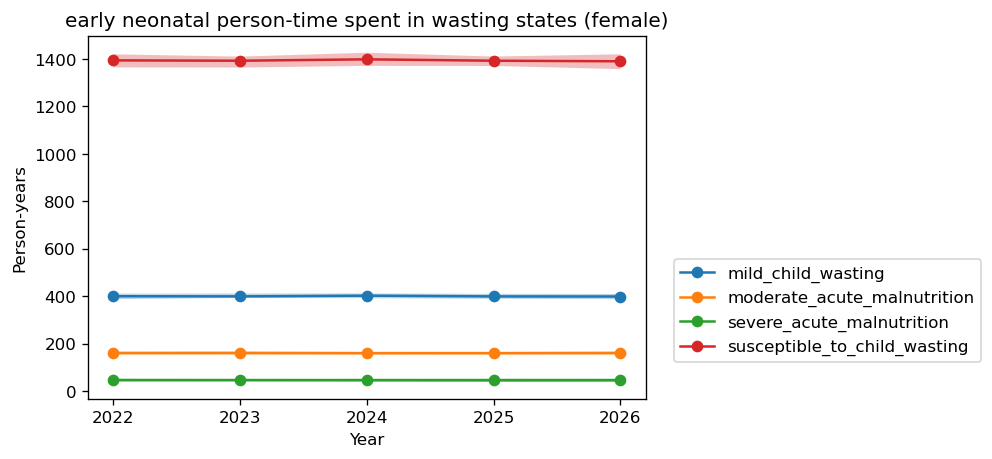

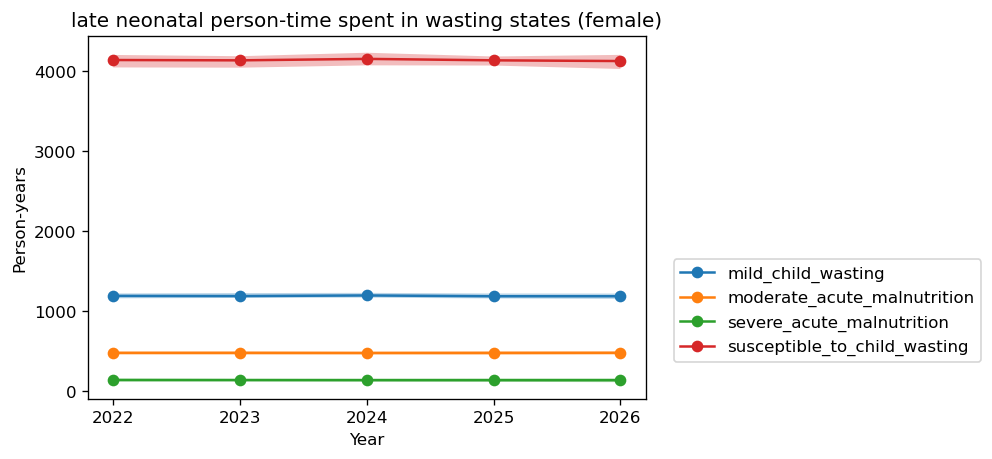

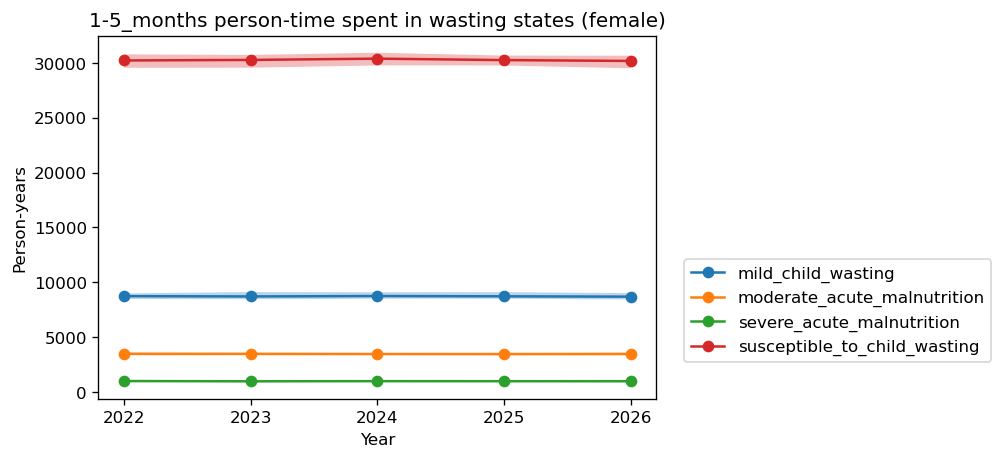

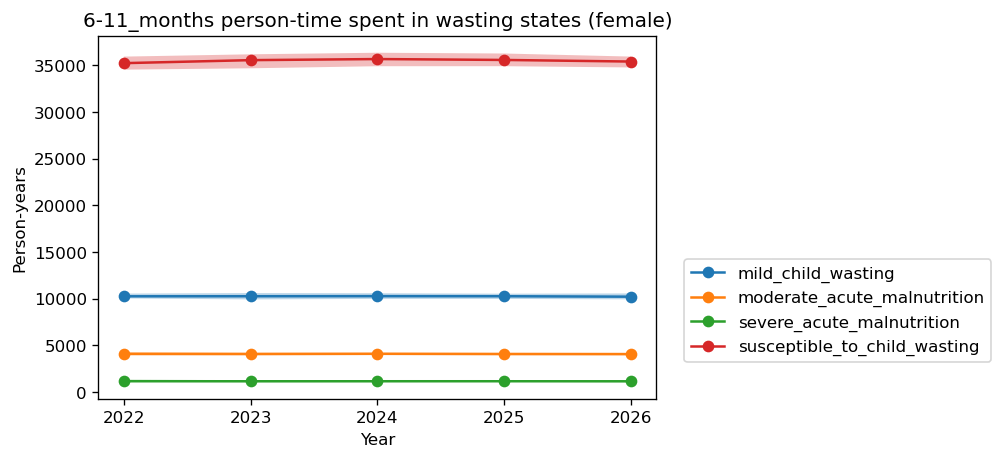

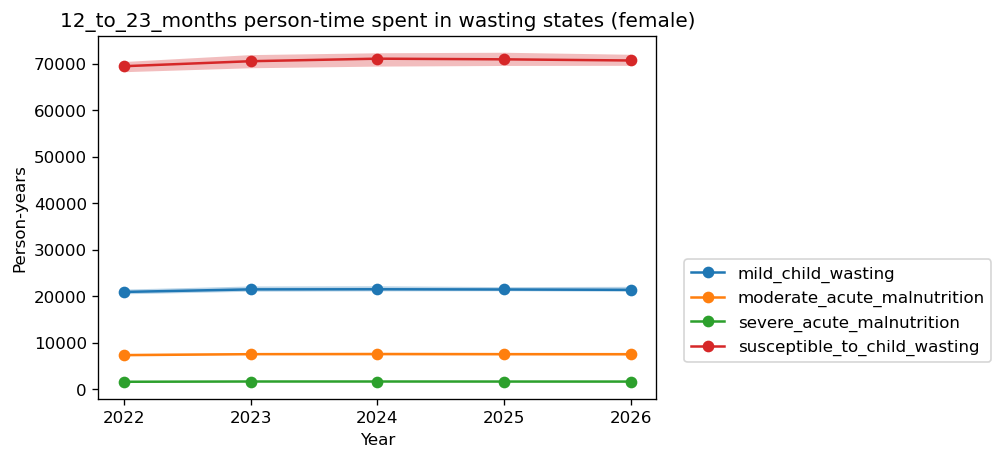

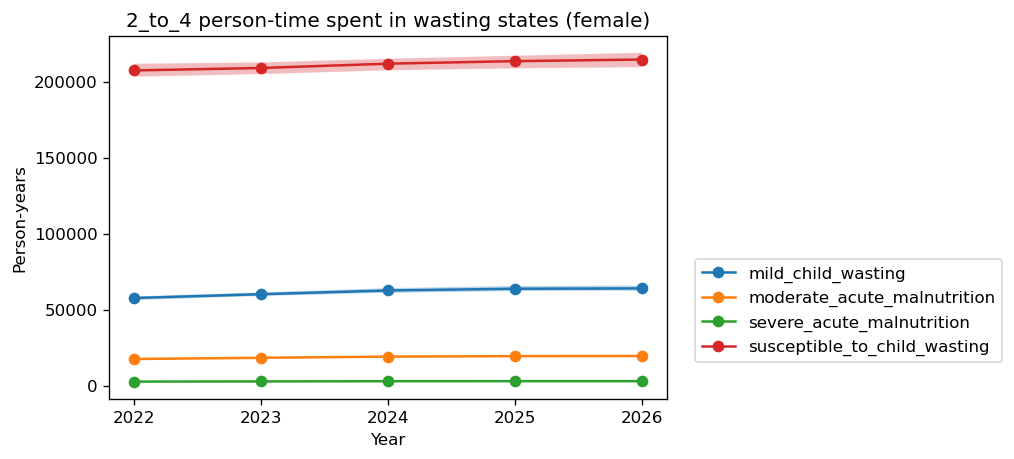

In [44]:
def plot_wasting_pt_over_time(df, sex, age_group):
    
    df.year = df.year.astype(int)
    state = df.cause.iloc[0]
    
    #{1: 'early_neonatal', 2: 'late_neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    age_map = {1:'early neonatal',2:'late neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    age = age_map[age_group]
    
    plt.figure(figsize=(6, 4), dpi=120)
    for cause in df.cause.unique():
        sub = df.loc[(df.sex==sex) & (df.age_group==age_group) & (df.cause==cause)]
        plt.plot(sub['year'], sub['mean'], marker='o', label=cause)
        plt.fill_between(sub['year'], sub['2.5%'], sub['97.5%'], alpha=.3)

    plt.legend(loc=(1.05, .1))
    plt.xlabel('Year')
    plt.ylabel('Person-years')
    plt.xticks(ticks = range(df.year.min(), df.year.max()+1))#, labels = ['early neonatal', 'late neonatal', 'post neonatal', '1 to 4'], rotation = 45) 
    plt.title(f'{age} person-time spent in wasting states ({sex})')

for age_group in pt_tmrel_wasting.age_group.unique():
    plot_wasting_pt_over_time(wasting_pt_df, sex = 'female', age_group = age_group)

In [45]:
def plot_sim_wasting(sim_data: pd.DataFrame, sex: str, sim_measure: str):
           
    ## add age label
    age_labels = {1:'early neonatal',2:'late neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    sim_data['age_label'] = sim_data.age_group.map(age_labels)
    
    
    plt.figure(figsize=(6, 4), dpi=120)
    
    for year in sim_data.year.unique():
        sim_sub = sim_data[(sim_data.scenario == 'baseline') & 
                           (sim_data.year == year) & 
                           (sim_data.sex == sex)]
        plt.plot(sim_sub['age_group'], sim_sub['mean'], marker='o', label=year)
        plt.fill_between(sim_sub['age_group'], sim_sub['2.5%'], sim_sub['97.5%'], alpha=.3)
    
    plt.title(f'{sim_measure}, {sex}')
    plt.xlabel('Age')
    plt.xticks(ticks = [1, 2, 3, 4, 5, 6], labels = ['early neonatal', 'late neonatal', '1-5mo', '6-11mo', '1-2y', '2-4y'], rotation = 45)
          
    plt.legend(loc=(1.05, .1))
    plt.grid()
    

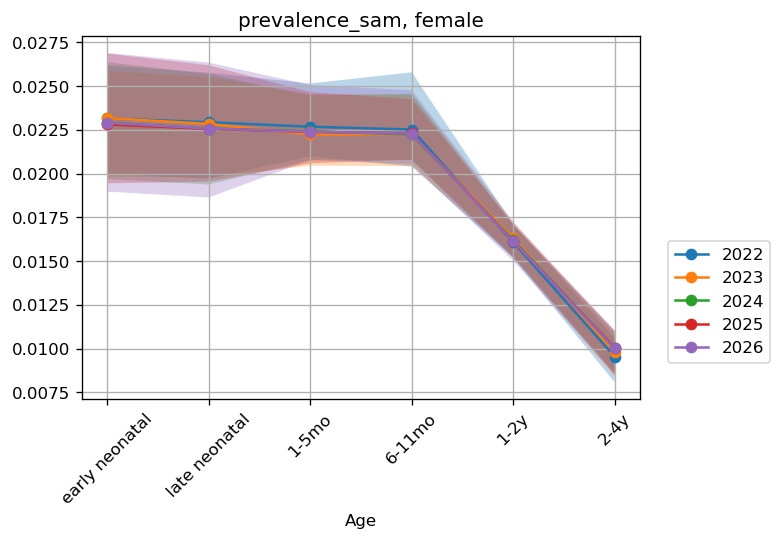

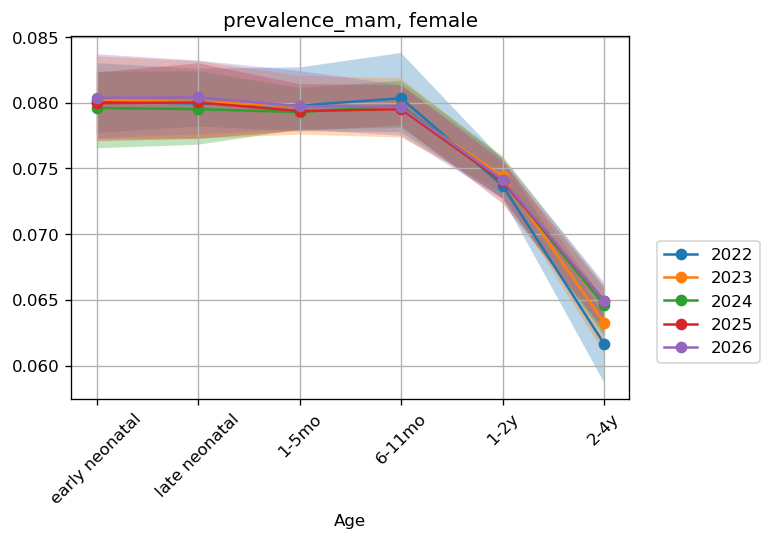

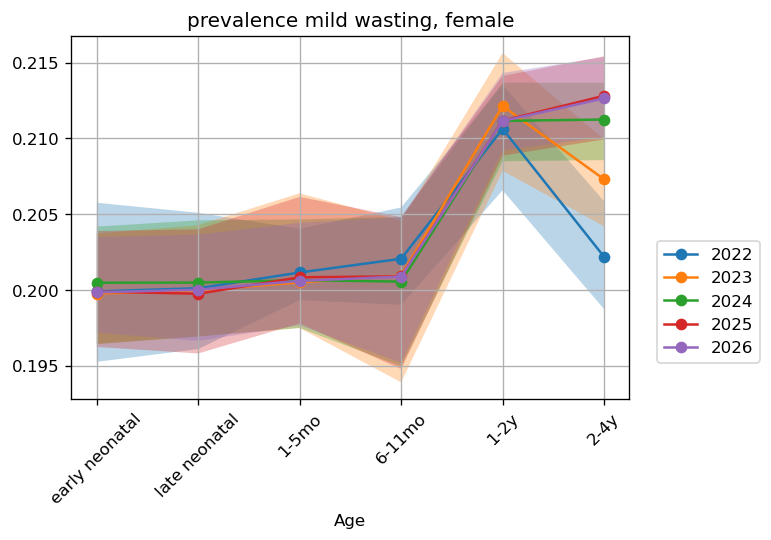

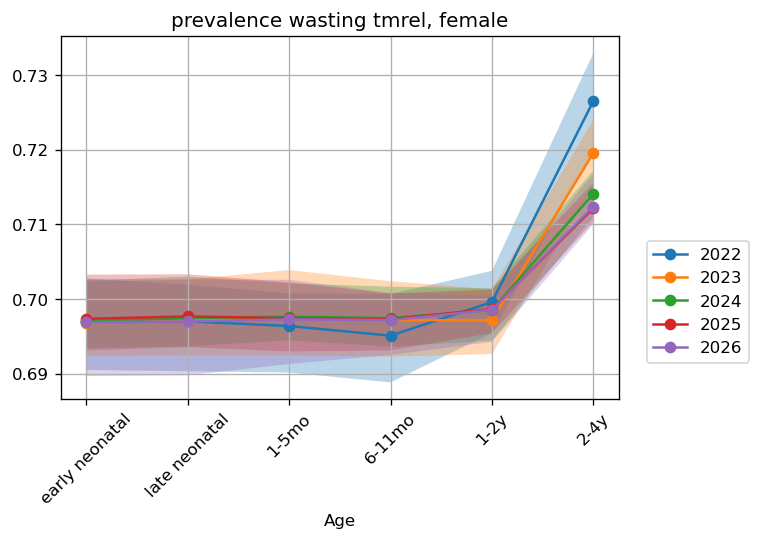

In [46]:
plot_sim_wasting(prevalence_sam, sex = 'female', sim_measure = 'prevalence_sam')
plot_sim_wasting(prevalence_mam, sex = 'female', sim_measure = 'prevalence_mam')
plot_sim_wasting(prevalence_mild, sex = 'female', sim_measure = 'prevalence mild wasting')
plot_sim_wasting(prevalence_wasting_tmrel, sex = 'female', sim_measure = 'prevalence wasting tmrel')

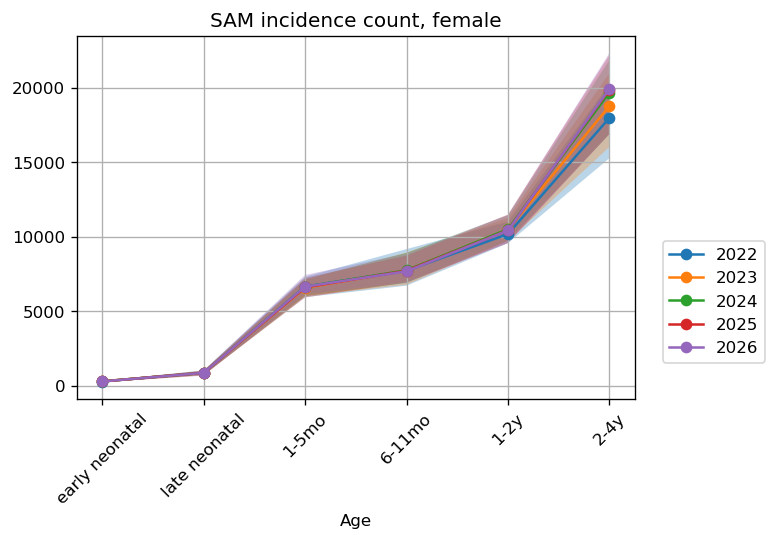

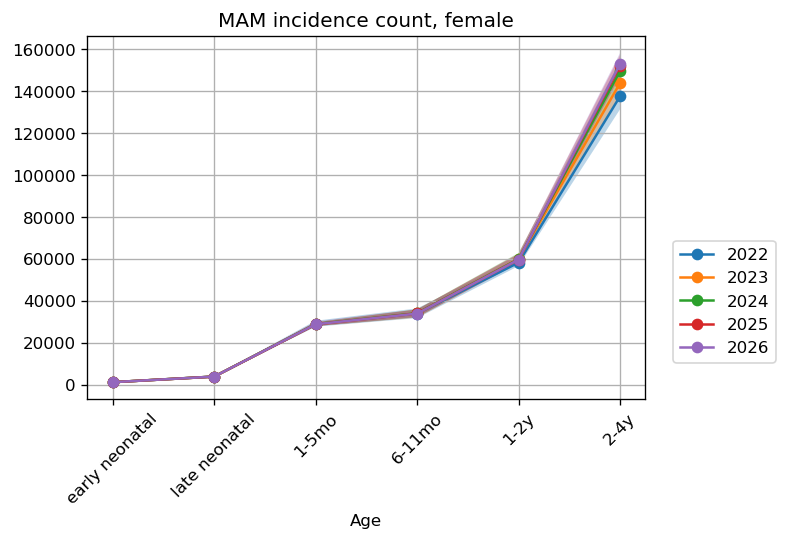

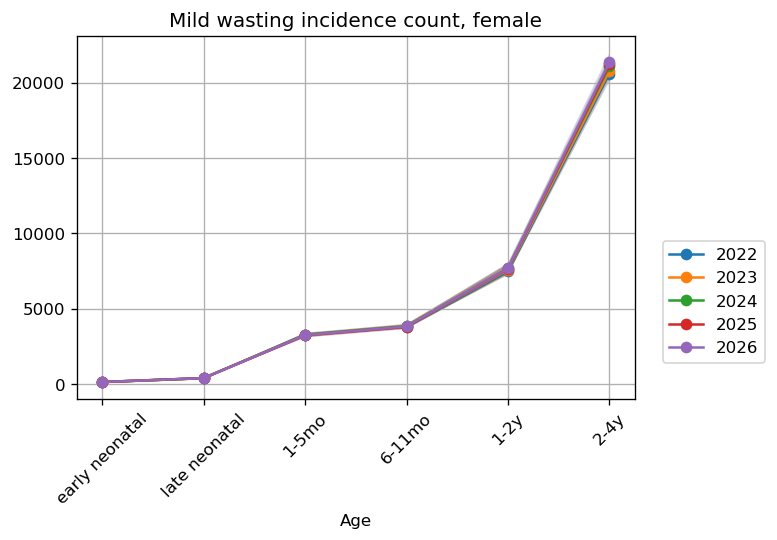

In [47]:
plot_sim_wasting(inc_count_sam, 'female', 'SAM incidence count')
plot_sim_wasting(inc_count_mam, 'female', 'MAM incidence count')
plot_sim_wasting(inc_count_mild, 'female', 'Mild wasting incidence count')

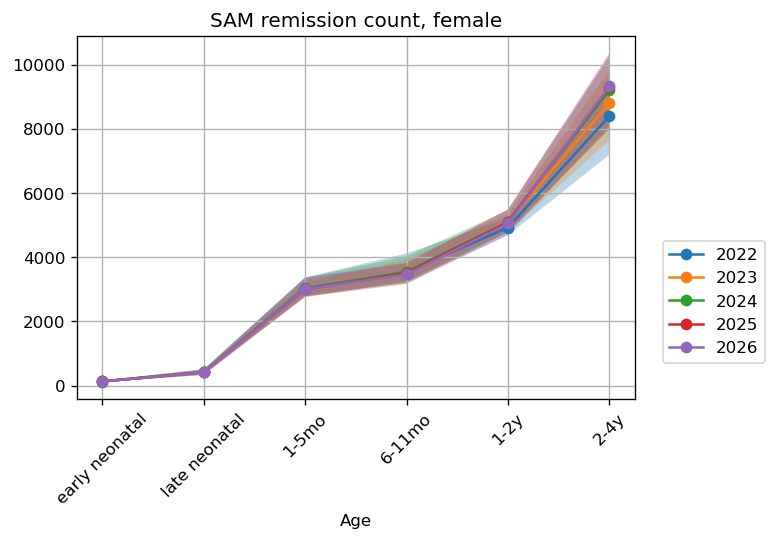

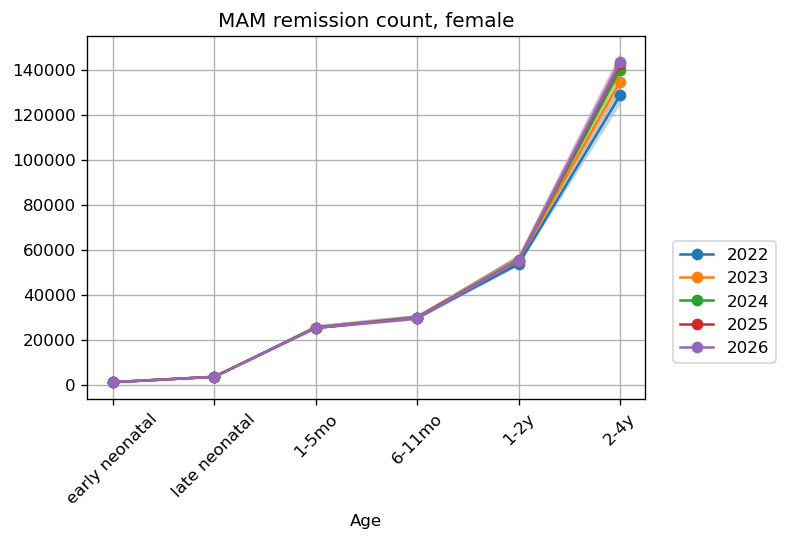

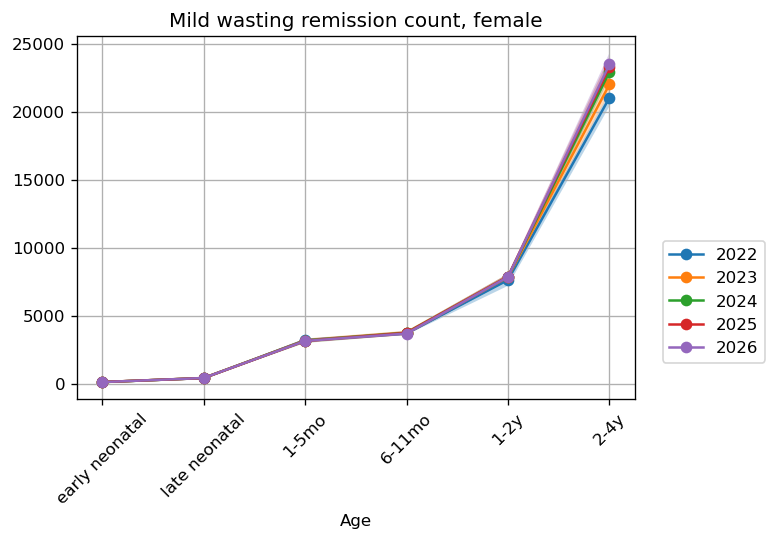

In [48]:
plot_sim_wasting(rem_count_sam, 'female', 'SAM remission count')
plot_sim_wasting(rem_count_mam, 'female', 'MAM remission count')
plot_sim_wasting(rem_count_mild, 'female', 'Mild wasting remission count')

In [49]:
art_wasting_prev.query("risk=='sam'")

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age,age_group,risk,measure
0,female,0.000000,0.019178,2020,2021,0.024109,0.020717,0.028874,early_neonatal,1,sam,prevalence
4,female,0.019178,0.076712,2020,2021,0.023822,0.017965,0.028097,late_neonatal,2,sam,prevalence
8,female,0.076712,0.500000,2020,2021,0.023814,0.020919,0.026497,1-5_months,3,sam,prevalence
12,female,0.500000,1.000000,2020,2021,0.023692,0.021159,0.027427,6-11_months,4,sam,prevalence
...,...,...,...,...,...,...,...,...,...,...,...,...
32,male,0.076712,0.500000,2020,2021,0.038729,0.034392,0.043029,1-5_months,3,sam,prevalence
36,male,0.500000,1.000000,2020,2021,0.036505,0.032077,0.039467,6-11_months,4,sam,prevalence
40,male,1.000000,2.000000,2020,2021,0.026518,0.022918,0.029731,12_to_23_months,5,sam,prevalence
44,male,2.000000,5.000000,2020,2021,0.014646,0.013089,0.015981,2_to_4,6,sam,prevalence


In [50]:
prevalence_sam

,age_group,sex,year,scenario,measure,cause,mean,2.5%,97.5%,age_label
0,1,female,2022,baseline,state_person_time,severe_acute_malnutrition,0.023153,0.019975,0.026174,early neonatal
1,1,female,2023,baseline,state_person_time,severe_acute_malnutrition,0.023168,0.019825,0.025866,early neonatal
2,1,female,2024,baseline,state_person_time,severe_acute_malnutrition,0.022906,0.019676,0.026362,early neonatal
3,1,female,2025,baseline,state_person_time,severe_acute_malnutrition,0.022806,0.019444,0.026853,early neonatal
...,...,...,...,...,...,...,...,...,...,...
56,6,male,2023,baseline,state_person_time,severe_acute_malnutrition,0.015548,0.013879,0.017047,2_to_4
57,6,male,2024,baseline,state_person_time,severe_acute_malnutrition,0.015887,0.014176,0.017415,2_to_4
58,6,male,2025,baseline,state_person_time,severe_acute_malnutrition,0.016011,0.014432,0.017467,2_to_4
59,6,male,2026,baseline,state_person_time,severe_acute_malnutrition,0.015882,0.014394,0.017213,2_to_4


In [51]:
prevalence_mam

,age_group,sex,year,scenario,measure,cause,mean,2.5%,97.5%,age_label
0,1,female,2022,baseline,state_person_time,moderate_acute_malnutrition,0.080061,0.077701,0.083004,early neonatal
1,1,female,2023,baseline,state_person_time,moderate_acute_malnutrition,0.080242,0.077237,0.083533,early neonatal
2,1,female,2024,baseline,state_person_time,moderate_acute_malnutrition,0.079600,0.076534,0.082360,early neonatal
3,1,female,2025,baseline,state_person_time,moderate_acute_malnutrition,0.079955,0.077073,0.082297,early neonatal
...,...,...,...,...,...,...,...,...,...,...
56,6,male,2023,baseline,state_person_time,moderate_acute_malnutrition,0.075663,0.073219,0.077888,2_to_4
57,6,male,2024,baseline,state_person_time,moderate_acute_malnutrition,0.077501,0.075416,0.079541,2_to_4
58,6,male,2025,baseline,state_person_time,moderate_acute_malnutrition,0.077866,0.075487,0.079710,2_to_4
59,6,male,2026,baseline,state_person_time,moderate_acute_malnutrition,0.077565,0.075192,0.079514,2_to_4


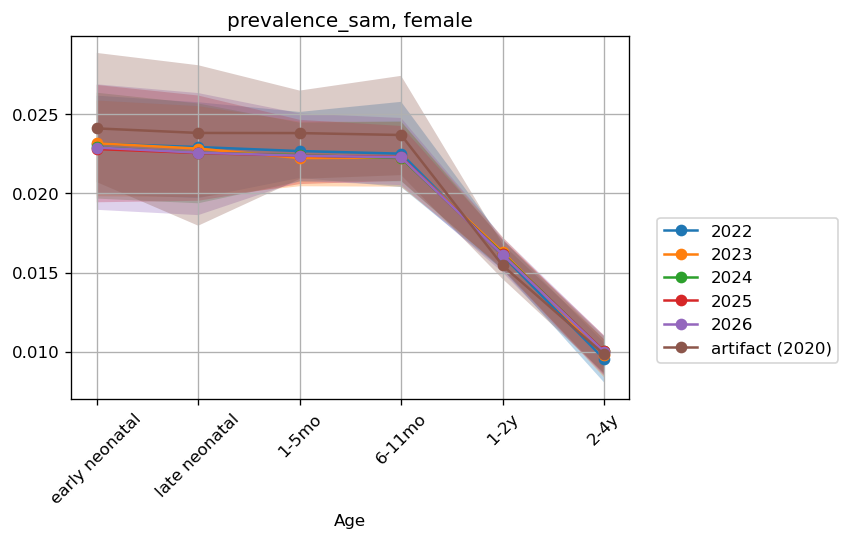

In [52]:
def plot_sim_vs_art_wasting(sim_data: pd.DataFrame, art_data: pd.DataFrame, sex: str, sim_measure: str):
           
    ## add age label
    age_labels = {1:'early neonatal',2:'late neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    sim_data['age_label'] = sim_data.age_group.map(age_labels)
    
    
    plt.figure(figsize=(6, 4), dpi=120)
    
    for year in sim_data.year.unique():
        sim_sub = sim_data[(sim_data.scenario == 'baseline') & 
                           (sim_data.year == year) & 
                           (sim_data.sex == sex)]
        plt.plot(sim_sub['age_group'], sim_sub['mean'], marker='o', label=year)
        plt.fill_between(sim_sub['age_group'], sim_sub['2.5%'], sim_sub['97.5%'], alpha=.3)
        
    art_sub = art_data.query("sex==@sex")
    plt.plot(art_sub['age_group'], art_sub['mean'], marker='o', label="artifact (2020)")
    plt.fill_between(art_sub['age_group'], art_sub['2.5%'], art_sub['97.5%'], alpha=.3)
    
    plt.title(f'{sim_measure}, {sex}')
    plt.xlabel('Age')
    plt.xticks(ticks = [1, 2, 3, 4, 5, 6], labels = ['early neonatal', 'late neonatal', '1-5mo', '6-11mo', '1-2y', '2-4y'], rotation = 45)
          
    plt.legend(loc=(1.05, .1))
    plt.grid()

plot_sim_vs_art_wasting(prevalence_sam, art_wasting_prev.query("risk=='sam'"), sex = 'female', sim_measure = 'prevalence_sam')

# Plot sim vs. all 1000 draws in artifact

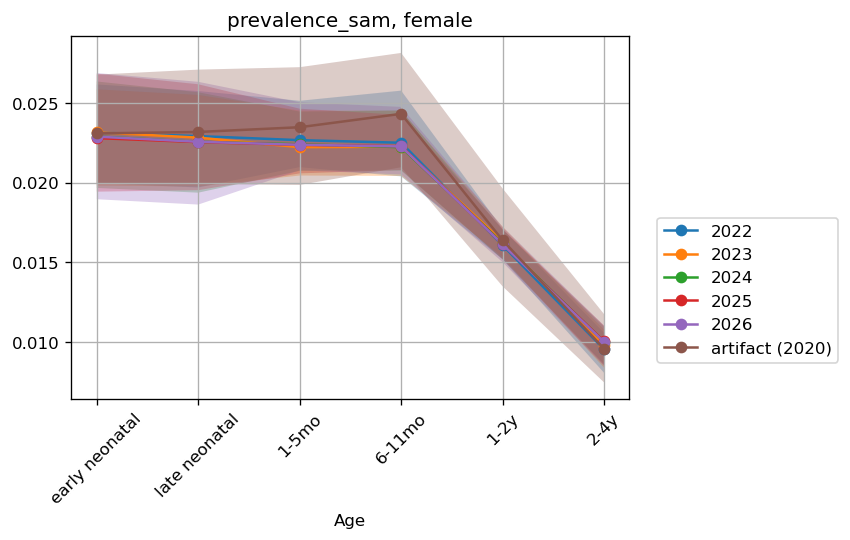

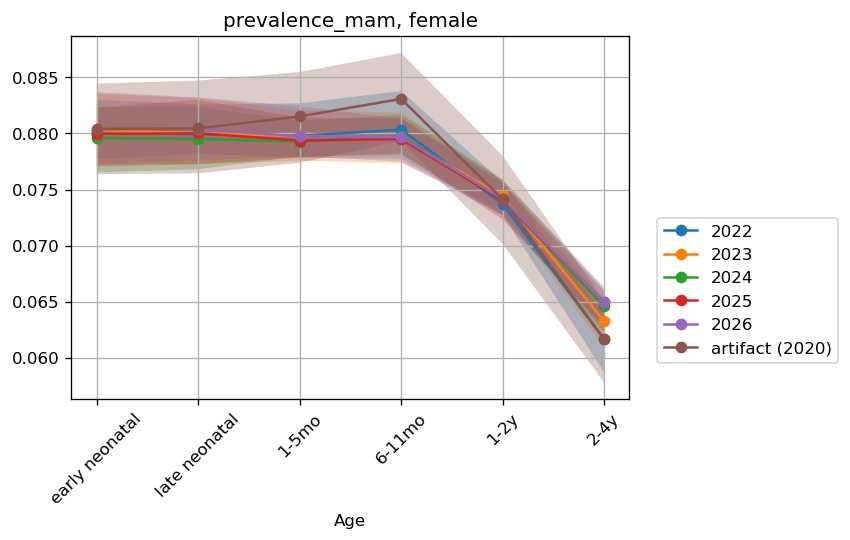

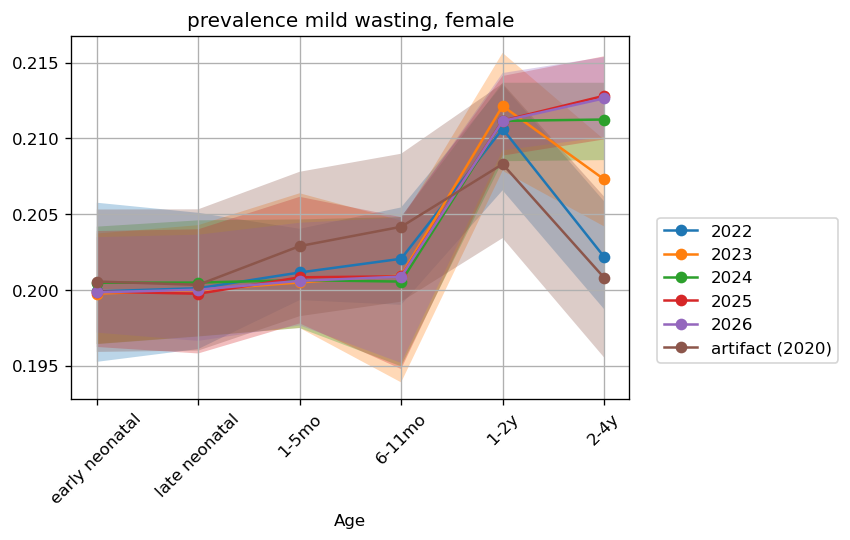

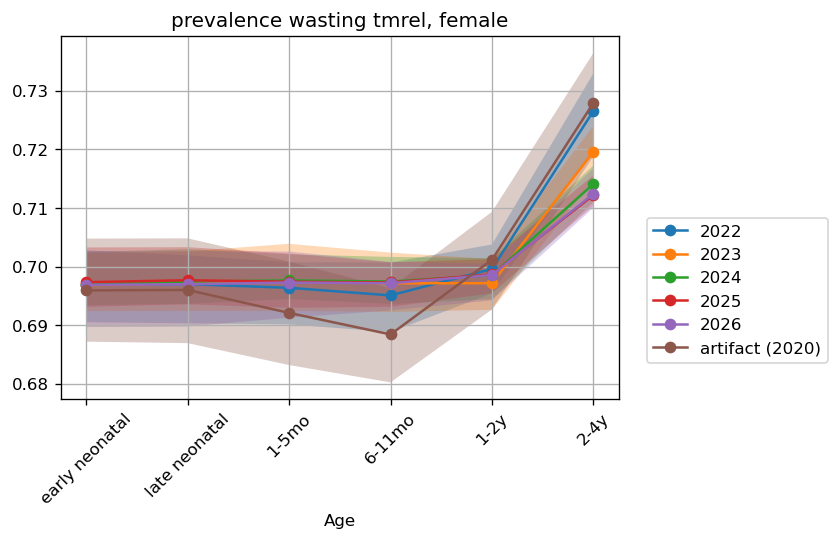

In [53]:
# plot_sim_vs_art_wasting(prevalence_sam, wasting_prev.query("risk=='sam'"), sex = 'female', sim_measure = 'prevalence_sam')
plot_sim_vs_art_wasting(prevalence_sam, sam_prev, sex = 'female', sim_measure = 'prevalence_sam')
plot_sim_vs_art_wasting(prevalence_mam, mam_prev, sex = 'female', sim_measure = 'prevalence_mam')
plot_sim_vs_art_wasting(prevalence_mild, mild_prev, sex = 'female', sim_measure = 'prevalence mild wasting')
plot_sim_vs_art_wasting(prevalence_wasting_tmrel, sus_wasting_prev, sex = 'female', sim_measure = 'prevalence wasting tmrel')

In [54]:
output_dir

'/home/j/Project/simulation_science/ciff_malnutrition/verification_and_validation/v2.4_corrected_fertility/'

In [55]:
ls /share/scratch/users/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/v2.3_wasting_birth_prevalence/

wasting_prevalence.pdf


In [56]:
art_wasting_prev['risk'].unique()

array(['sam', 'mam', 'mild_wasting', 'tmrel_wasting'], dtype=object)

In [57]:
prevalence_sam

,age_group,sex,year,scenario,measure,cause,mean,2.5%,97.5%,age_label
0,1,female,2022,baseline,state_person_time,severe_acute_malnutrition,0.023153,0.019975,0.026174,early neonatal
1,1,female,2023,baseline,state_person_time,severe_acute_malnutrition,0.023168,0.019825,0.025866,early neonatal
2,1,female,2024,baseline,state_person_time,severe_acute_malnutrition,0.022906,0.019676,0.026362,early neonatal
3,1,female,2025,baseline,state_person_time,severe_acute_malnutrition,0.022806,0.019444,0.026853,early neonatal
...,...,...,...,...,...,...,...,...,...,...
56,6,male,2023,baseline,state_person_time,severe_acute_malnutrition,0.015548,0.013879,0.017047,2_to_4
57,6,male,2024,baseline,state_person_time,severe_acute_malnutrition,0.015887,0.014176,0.017415,2_to_4
58,6,male,2025,baseline,state_person_time,severe_acute_malnutrition,0.016011,0.014432,0.017467,2_to_4
59,6,male,2026,baseline,state_person_time,severe_acute_malnutrition,0.015882,0.014394,0.017213,2_to_4


In [58]:
sim_wasting_prev = (
    pd.concat([prevalence_sam, prevalence_mam, prevalence_mild, prevalence_wasting_tmrel], ignore_index=True)
    .assign(
        risk=lambda df: df['cause'].map(
            {'severe_acute_malnutrition': 'sam',
             'moderate_acute_malnutrition': 'mam',
             'mild_child_wasting': 'mild_wasting',
             'susceptible_to_child_wasting': 'tmrel_wasting'
            })
           )
)
sim_wasting_prev

,age_group,sex,year,scenario,measure,cause,mean,2.5%,97.5%,age_label,risk
0,1,female,2022,baseline,state_person_time,severe_acute_malnutrition,0.023153,0.019975,0.026174,early neonatal,sam
1,1,female,2023,baseline,state_person_time,severe_acute_malnutrition,0.023168,0.019825,0.025866,early neonatal,sam
2,1,female,2024,baseline,state_person_time,severe_acute_malnutrition,0.022906,0.019676,0.026362,early neonatal,sam
3,1,female,2025,baseline,state_person_time,severe_acute_malnutrition,0.022806,0.019444,0.026853,early neonatal,sam
...,...,...,...,...,...,...,...,...,...,...,...
236,6,male,2023,baseline,state_person_time,susceptible_to_child_wasting,0.687339,0.681888,0.691037,2_to_4,tmrel_wasting
237,6,male,2024,baseline,state_person_time,susceptible_to_child_wasting,0.680104,0.676265,0.683438,2_to_4,tmrel_wasting
238,6,male,2025,baseline,state_person_time,susceptible_to_child_wasting,0.678510,0.675418,0.681167,2_to_4,tmrel_wasting
239,6,male,2026,baseline,state_person_time,susceptible_to_child_wasting,0.679635,0.676681,0.682546,2_to_4,tmrel_wasting


# Plot sim vs. artifact with draws filtered to those in sim

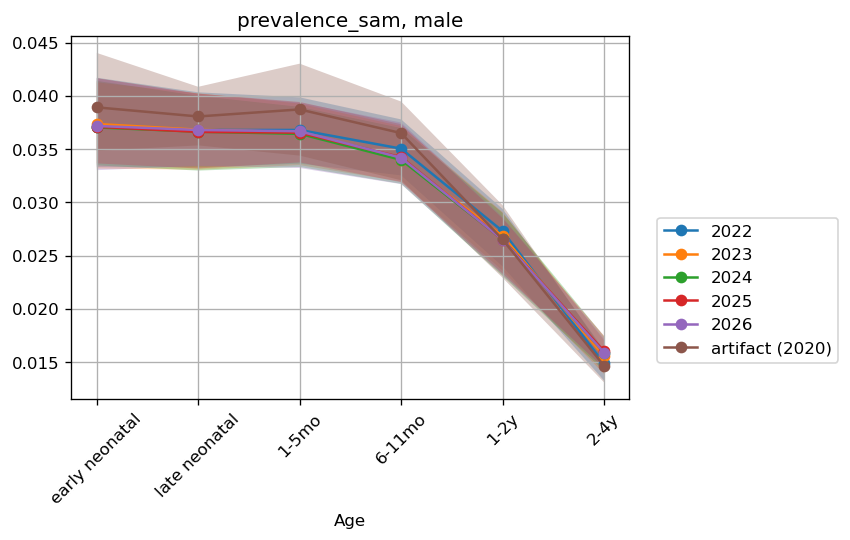

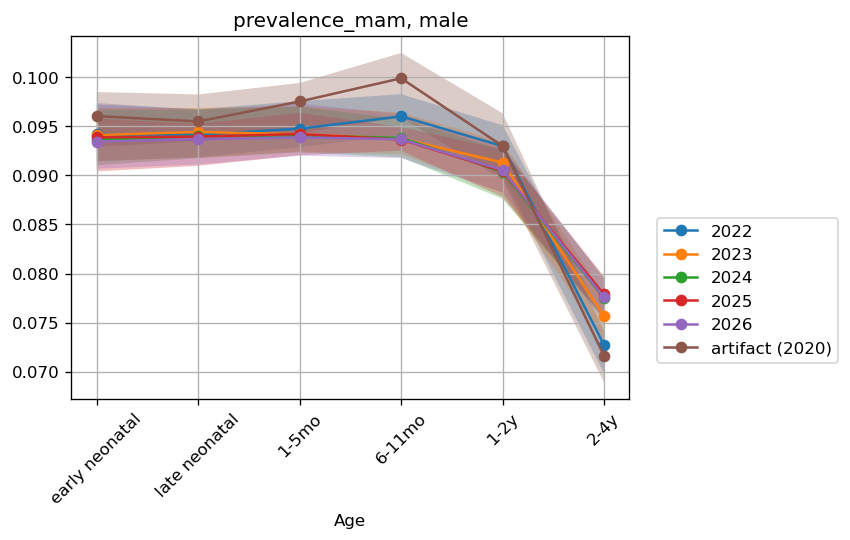

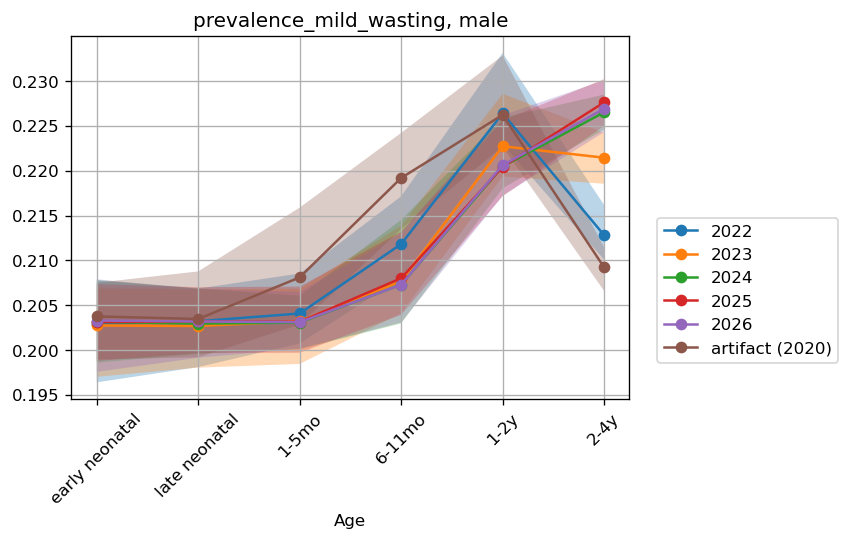

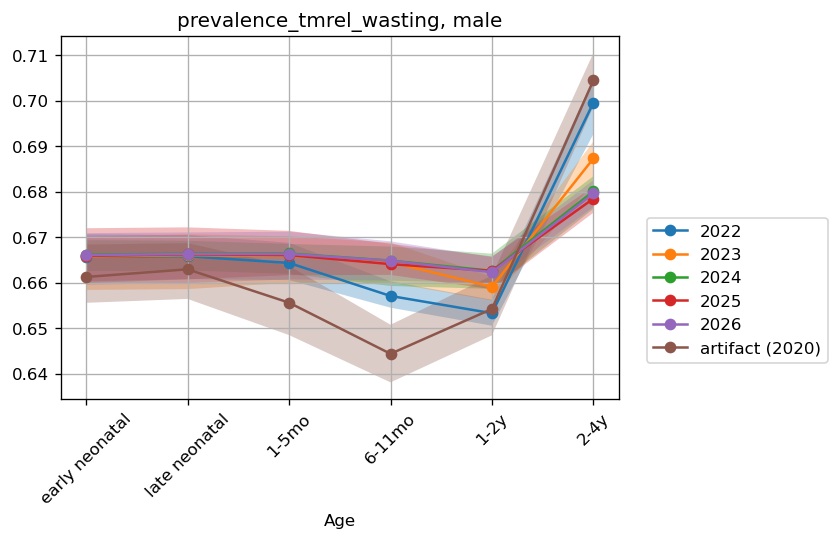

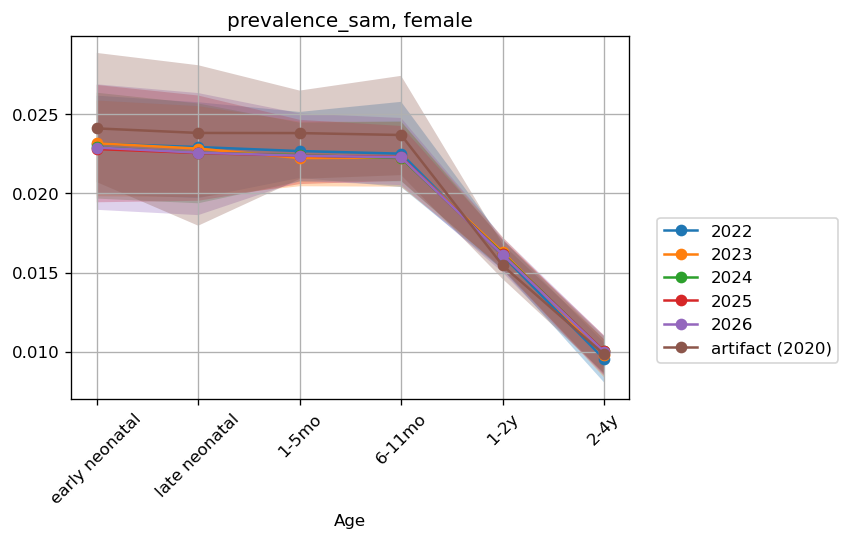

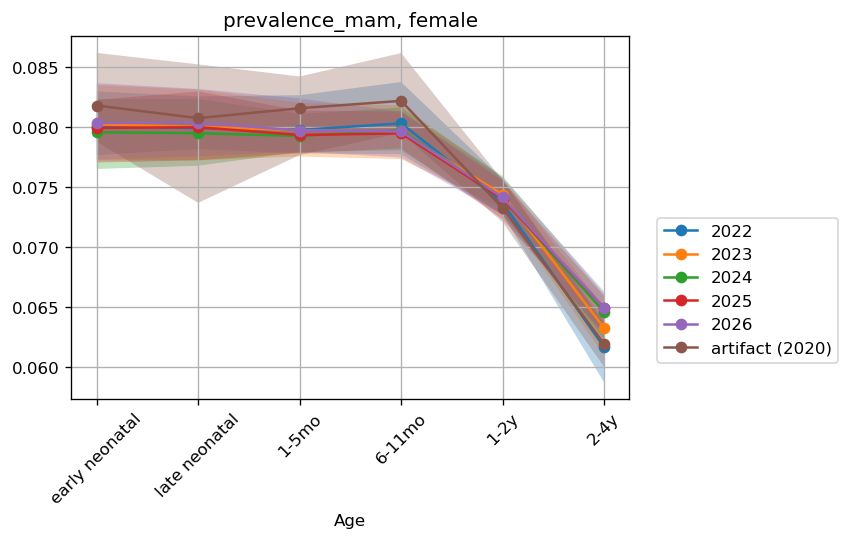

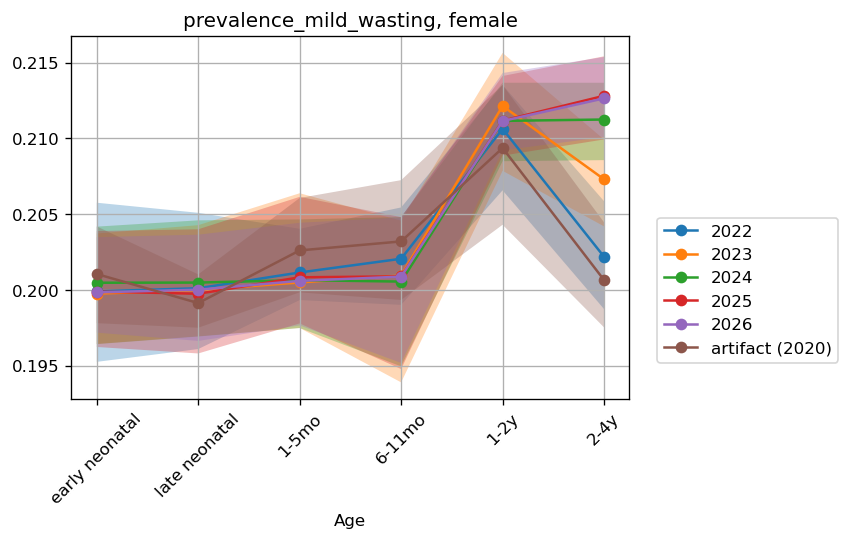

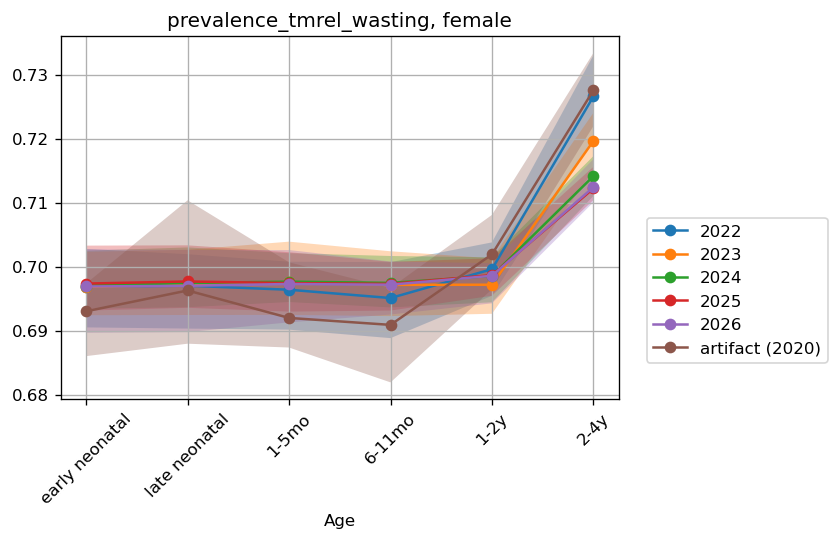

In [59]:
with PdfPages(output_dir + 'wasting_prevalence(filtered_draws).pdf') as pdf:
    for sex in ('male', 'female'):
        for risk_cat in ('sam', 'mam', 'mild_wasting', 'tmrel_wasting'):
            plot_sim_vs_art_wasting(
                sim_wasting_prev.query('risk==@risk_cat'),
                art_wasting_prev.query('risk==@risk_cat'),
                sex = sex,
                sim_measure = f'prevalence_{risk_cat}'
            )
            pdf.savefig(bbox_inches='tight')

In [60]:
ls /share/scratch/users/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/v2.3_wasting_birth_prevalence/

wasting_prevalence.pdf
